In [1]:
import os
from pathlib import Path
from joblib import Parallel, delayed

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

from tensorflow.keras.utils import image_dataset_from_directory, load_img, img_to_array 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AvgPool2D, Flatten, Dense, Dropout, RandomFlip, RandomRotation, RandomZoom, Rescaling, Input, Lambda
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.wrappers import SKLearnRegressor
from tensorboard.backend.event_processing import event_accumulator
from collections import Counter


# Data

In [2]:
# pass thru tf to convert paths to images
def preprocess_image(file_path, label):
    # final_path_file = data_dir+"/"+file_path
    img = tf.io.read_file(file_path)
    # rgb, later we normalize
    img = tf.image.decode_image(img, channels=3)
    # todo: make it optional passing to grayscale
    if grayscale:
        img = tf.image.rgb_to_grayscale(img)
        img.set_shape([None, None, 1])
    else:
        img.set_shape([None, None, 3]) #rgb
    img = tf.image.resize(img, image_size)
    return img, tf.one_hot(label, depth=len(class_names))

In [3]:
data_dir = "../data"
original_size = (300,200)
image_size = (37, 25)
batch_size = 32

file_paths = []
labels = []
class_names = os.listdir(data_dir)
class_to_index = {name: i for i, name in enumerate(class_names)}

for class_name in class_names:
    class_dir = f"{data_dir}/{class_name}"
    images = sorted(os.listdir(class_dir))
    for img_path in images:
        file_paths.append(class_dir + "/" + str(img_path))
        labels.append(class_to_index[class_name])

file_paths = np.array(file_paths)
labels = np.array(labels)
grayscale = False

X_train, X_val, y_train, y_val = train_test_split(
    file_paths,
    labels,
    test_size=0.2,
    stratify=labels,
    random_state=42
)

# for CV
cv_train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))
cv_train_set = cv_train_set.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
cv_train_set = cv_train_set.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

cv_test_set = tf.data.Dataset.from_tensor_slices((X_val, y_val))
cv_test_set = cv_test_set.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
cv_test_set = cv_test_set.batch(batch_size).prefetch(tf.data.AUTOTUNE)


X_val, X_test, y_val, y_test = train_test_split(
    X_val,
    y_val,
    test_size=0.5,
    stratify=y_val,
    random_state=42
)

# for iteration over models
train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_set = train_set.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_set = train_set.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_set = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_set = val_set.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_set = val_set.batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_set = test_set.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_set = test_set.batch(batch_size).prefetch(tf.data.AUTOTUNE)


In [4]:
def count_label_distribution(dset):
    label_array = [x[1] for x in dset]
    
    labels_in_dset = []
    for x in label_array:
        labels_in_dset.extend(np.argmax(x, axis = 1))
    
    return len(labels_in_dset), Counter(labels_in_dset)
    

In [5]:
total_train, train_label_count = count_label_distribution(train_set)
total_val, val_label_count = count_label_distribution(val_set)
total_test, test_label_count = count_label_distribution(test_set)

total_cv_train, cv_train_label_count = count_label_distribution(cv_train_set)
total_cv_test, cv_test_label_count = count_label_distribution(cv_test_set)


In [6]:
train_label_count,val_label_count, test_label_count,cv_train_label_count,cv_test_label_count

(Counter({np.int64(2): 600, np.int64(1): 581, np.int64(0): 569}),
 Counter({np.int64(2): 75, np.int64(1): 73, np.int64(0): 71}),
 Counter({np.int64(2): 75, np.int64(0): 72, np.int64(1): 72}),
 Counter({np.int64(2): 600, np.int64(1): 581, np.int64(0): 569}),
 Counter({np.int64(2): 150, np.int64(1): 145, np.int64(0): 143}))

In [7]:
sum([total_train, total_val, total_test])

2188

In [8]:
len(file_paths)

2188

# Model

## Data Augmentation

In [9]:
# vertical here should only make sense since images are right-oriented
data_augmentation = Sequential([
    RandomFlip("vertical"),
    RandomRotation(0.05),
    RandomZoom(0.05)
])

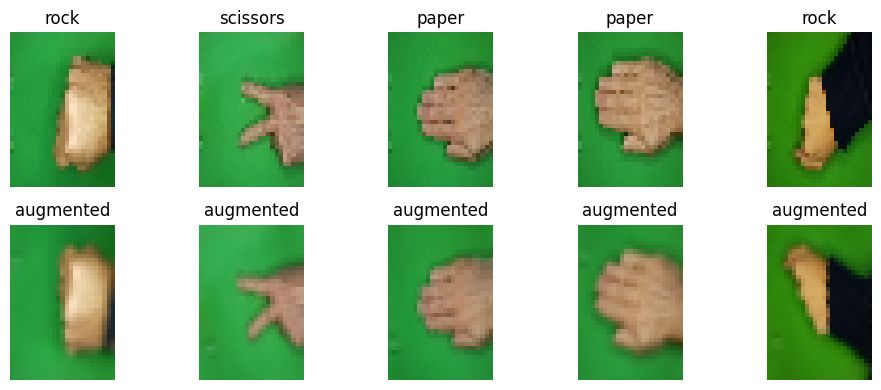

In [10]:
for images, label in train_set.take(1):
    augmented_images = data_augmentation(images)

    num_images = 5
    plt.figure(figsize=(10, 4))

    for i in range(num_images):
        # original
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(label[i])])
        plt.axis("off")

        # aug
        ax = plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.title("augmented")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

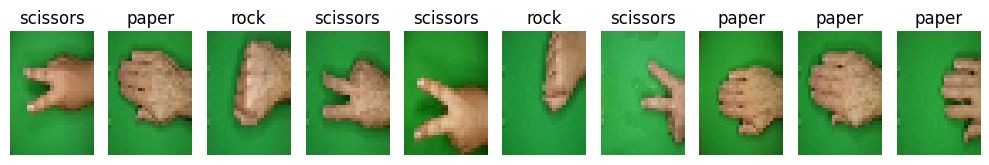

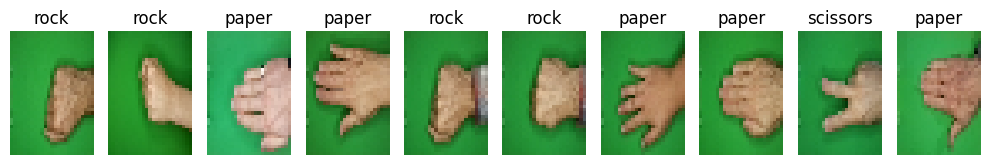

In [11]:
for images, label in val_set.take(2):
    # augmented_images = data_augmentation(images)
    num_images = 10
    plt.figure(figsize=(10, 4))
    for i in range(num_images):
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(label[i])])
        plt.axis("off")
        

    plt.tight_layout()
    plt.show()

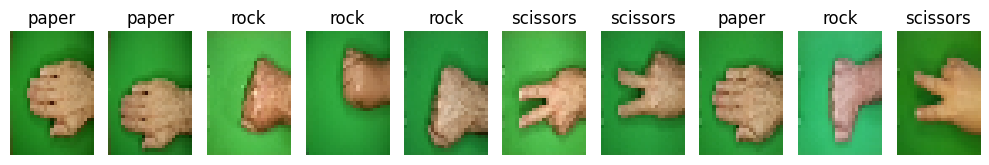

In [12]:
for images, label in test_set.take(1):
    # augmented_images = data_augmentation(images)
    num_images = 10
    plt.figure(figsize=(10, 4))
    for i in range(num_images):
        ax = plt.subplot(2, num_images, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(label[i])])
        plt.axis("off")
        

    plt.tight_layout()
    plt.show()

In [13]:
def show_misclassified_images(model, dataset, class_names, n=9):
    import numpy as np

    images = []
    true_labels = []
    pred_labels = []

    for img_batch, label_batch in dataset.unbatch().batch(1).take(1000):
        preds = model.predict(img_batch, verbose=0)
        pred_class = tf.argmax(preds[0])
        true_class = tf.argmax(label_batch[0])

        if pred_class != true_class:
            images.append(img_batch[0].numpy())
            true_labels.append(class_names[true_class.numpy()])
            pred_labels.append(class_names[pred_class.numpy()])

        if len(images) >= n:
            break

    plt.figure(figsize=(15, 10))
    for i in range(len(images)):
        plt.subplot(3, 3, i+1)

        img = images[i]
        if img.max() <= 1.0:
            img = img * 255.0
        img = np.clip(img.astype("uint8"), 0, 255)

        plt.imshow(img)
        plt.title(f"true: {true_labels[i]}\npred: {pred_labels[i]}", color='red')
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [14]:
def show_filters(model, layer_number = 2):
    filters, biases = model.layers[2].get_weights()

    # normalize
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)

    n_filters = filters.shape[3]
    grid_size = 32
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(20, 20))

    for i in range(grid_size * grid_size):
        ax = axs[i // grid_size, i % grid_size]
        ax.axis('off')
        
        if i < n_filters:
            f = filters[:, :, :, i]
            if f.shape[2] == 3:  # if rgb
                ax.imshow(f)
            else:  # grayscale
                ax.imshow(f[:, :, 0], cmap='gray')
        else:
            ax.set_visible(False)

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()


## First

In [15]:
which_model = "first_architecture"

def root_logdir(architecture_name):
    return os.path.join(os.curdir, "logs\\"+architecture_name)

def get_run_logdir(architecture_name, it):
    import time
    run_id = str(it) +"_"+ time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return run_id, os.path.join(root_logdir(architecture_name), run_id)

def table_from_history(history_table, run_id):
    dft = pd.DataFrame(history_table)
    dft['run'] = run_id
    dft = dft.reset_index(names = "epoch")
    return dft 

In [16]:
def pass_batchs_to_arrays(dset, pass_dummy = False):

    X_list = []
    y_list = []

    for x_batch, y_batch in dset:
        X_list.append(x_batch.numpy())
        y_list.append(y_batch.numpy())

    X = np.concatenate(X_list, axis=0)
    y = np.concatenate(y_list, axis=0)
    
    if pass_dummy:
        y = np.argmax(y, axis = 1)
    
    return X, y


In [17]:
def compute_classification_metrics(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    str_summary = classification_report(y_true, y_pred, target_names=class_names)
    print(str_summary)
    
    # todo: manually compute other metrics
    return cm

In [18]:
def plot_conf_matrix(cm):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("pred")
    plt.ylabel("true")
    plt.show()

### Using CV

- CV would give us slightly better results and also we can use it for hyperparameter tuning

In [19]:
normalization_layer = Rescaling(1./255)
data_augmentation = Sequential([
    RandomFlip("vertical"),
    RandomRotation(0.05),
    RandomZoom(0.05)
])

if grayscale:
    dimension = 1
else:
    dimension = 3

def build_first_model(n_filters = 64, n_neurons = 64, learning_rate = 1e-2, momentum = 0.0, 
                      kernel_size = 3, pool_size = 2, sparse = True, **kwargs):
    
    #todo: true/false data augmentation
    model = Sequential([
    Input(shape = (image_size[0], image_size[1], dimension)),
    normalization_layer,
    data_augmentation,
    Conv2D(n_filters, kernel_size, activation = "relu", padding = "same"),
    MaxPooling2D(pool_size),
    Flatten(),
    Dense(n_neurons, activation="relu"),
    Dense(3, activation = "softmax")
                    ])
    
    optimizer = SGD(learning_rate=learning_rate, momentum=momentum)
    
    loss = "categorical_crossentropy"
    if sparse:
        loss = "sparse_categorical_crossentropy"
    model.compile(loss = loss,
        optimizer = optimizer,
        metrics = ["accuracy"])
    
    return model

In [20]:
X_train_array, y_train_array = pass_batchs_to_arrays(cv_train_set, pass_dummy=True)

In [38]:
def CNN_GridSearchCV_non_parallel(X_train_array, y_train_array, param_grid, random_state, n_splits = 5, shuffle = True):

    mean_scores = []

    skf = StratifiedKFold(n_splits=n_splits, shuffle = shuffle, random_state=random_state)

    param_combinations = [
        dict(zip(param_grid.keys(), values))
        for values in itertools.product(*param_grid.values())
    ]

    for i_p, params in enumerate(param_combinations):
        
        history_tables = []
        print("params: " + str(params))
        print("-"*10)
        # iterate first through each of the folds (with tuning)
        for i, (train_i, val_i) in enumerate(skf.split(X_train_array, y_train_array)):
            fold = f"Fold{i+1}"
            # print(fold)
            
            # data
            X_train, y_train = X_train_array[train_i], y_train_array[train_i]
            X_val, y_val = X_train_array[val_i], y_train_array[val_i]
            
            model = build_first_model(**params)
            
            # if we want to later check CV results
            run_id, run_logdir = get_run_logdir("first_architecture", f"ip_{i_p}"+fold)
            
            history = model.fit(X_train, y_train, validation_data=(X_val,y_val), 
                                epochs=30, verbose = 0)
            
            history_tables.append(table_from_history(history.history, run_id))
        
        df_history = pd.concat(history_tables)
        # same as best_model_checkpoint / checks the epoch where the model had its lowest loss
        best_train_val = df_history.groupby('run').apply(lambda x: x.loc[x["val_loss"].idxmin()], include_groups = False).reset_index()
        
        val_loss, val_accuracy = (best_train_val['val_loss'].mean(), best_train_val['val_accuracy'].mean())
        mean_scores.append((val_loss, val_accuracy))
        
        # print("-"*10)
        if i_p == 0:
            best_params = params
            best_accuracy = val_accuracy
        else:
            if val_accuracy > best_accuracy:
                best_params = params
                best_accuracy = val_accuracy
                print(f"*new_best | score: {val_accuracy}")
        print(" ")
    return best_params, best_accuracy, mean_scores
    

In [50]:
def evaluate_combination(i_p, params, X_train_array, y_train_array, skf, build_model):
    history_tables = []
    
    print(f"params: {params}")
    print("-" * 10)

    for i, (train_i, val_i) in enumerate(skf.split(X_train_array, y_train_array)):
        fold = f"Fold{i+1}"
        X_train, y_train = X_train_array[train_i], y_train_array[train_i]
        X_val, y_val = X_train_array[val_i], y_train_array[val_i]

        # model = build_first_model(**params)
        model = build_model(**params)
        run_id, run_logdir = get_run_logdir("first_architecture", f"ip_{i_p}"+fold)

        history = model.fit(X_train, y_train, validation_data=(X_val, y_val),
                            epochs=30, verbose=0)

        history_tables.append(table_from_history(history.history, run_id))

    df_history = pd.concat(history_tables)
    best_train_val = df_history.groupby('run').apply(
        lambda x: x.loc[x["val_loss"].idxmin()],
        include_groups=False
    ).reset_index()

    val_loss = best_train_val['val_loss'].mean()
    val_accuracy = best_train_val['val_accuracy'].mean()

    return {
        'index': i_p,
        'params': params,
        'val_loss': val_loss,
        'val_accuracy': val_accuracy
    }


In [51]:
def CNN_GridSearchCV(X_train_array, y_train_array, param_grid, build_model,random_state, n_splits=5, shuffle=True, n_jobs=1):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)

    param_combinations = [
        dict(zip(param_grid.keys(), values))
        for values in itertools.product(*param_grid.values())
    ]

    # if 1 then it's sequential
    results = Parallel(n_jobs=n_jobs)(
        delayed(evaluate_combination)(i, params, X_train_array, y_train_array, skf, build_model)
        for i, params in enumerate(param_combinations)
    )

    best_result = max(results, key=lambda r: r['val_accuracy'])
    best_params = best_result['params']
    best_accuracy = best_result['val_accuracy']

    mean_scores = [(r['val_loss'], r['val_accuracy']) for r in results]

    return best_params, best_accuracy, mean_scores


In [52]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 0


In [53]:
param_grid = {"learning_rate": [1e-2, 1e-4],
              "momentum": [0.0, 0.9],
              "kernel_size": [3,5],
              "n_filters": [64, 128],
              "n_neurons": [64, 128]}

In [54]:
best_params, best_accuracy, mean_scores  = CNN_GridSearchCV(X_train_array, y_train_array, param_grid, build_first_model, 42, 2, n_jobs = -1)

KeyboardInterrupt: 

In [40]:
best_params, best_accuracy

({'learning_rate': 0.01,
  'momentum': 0.9,
  'kernel_size': 5,
  'n_filters': 64,
  'n_neurons': 128},
 np.float64(0.9885714173316955))

In [41]:
model = build_first_model(**best_params, sparse= False)
model.fit(cv_train_set, epochs=30)

Epoch 1/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4085 - loss: 1.0586
Epoch 2/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7663 - loss: 0.6290
Epoch 3/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8488 - loss: 0.4285
Epoch 4/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9083 - loss: 0.2708
Epoch 5/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9344 - loss: 0.1868
Epoch 6/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9563 - loss: 0.1440
Epoch 7/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9623 - loss: 0.1473
Epoch 8/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9617 - loss: 0.1137
Epoch 9/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9652 - loss: 0.1051
Epoch 10/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9649 - loss: 0.1004
Epoch 11/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9731 - loss: 0.0783
Epoch 12/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9652 - lo

In [42]:
model.evaluate(cv_test_set)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9836 - loss: 0.0391


[0.03406902030110359, 0.9885844588279724]

In [44]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 37, 25, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 37, 25, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 37, 25, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 18, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 13824)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     1,769,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,549,704 (13.54 MB)

 Trainable params: 1,774,851 (6.77 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,774,853 (6.77 MB)

## Second

## Third